<a href="https://colab.research.google.com/github/masoudinejad/dt_pruning/blob/main/orap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/masoudinejad/dt_pruning/HEAD)

# Optimized Resource Aware Pruning (ORAP)

In this session you will see:
- [1 - Resource demand calculation of decision trees](#1)
- [2 - The general concept of global optimization](#2) 
- [3 - ORAP algorithm](#3)
- [4 - ORAP Performance](#4)
- [5 - ORAP vs CCP](#5)

Loading packages and preparing the basics

In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from ExtendDT import ext_dt
from orapMethod import *

Loading a sample dataset and train a decision tree to it.

In [2]:
X, y = load_wine(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=7)
cls_dt = DecisionTreeClassifier(random_state=0)
_ = cls_dt.fit(X_train, y_train)

<a name="1"></a>
## 1 - Decision tree resource demand


Different type of resources

Formulation of the APD

<a name="2"></a>
## 2 - Pruning as an optimization problem 

Pruning in a general sense is a process of removing a set of branches. Traditionally is has the goal of reducing/removing the over-fitting. Therefore, as long as the over-fitting is avoided pruning has done its job properly, regardless of the criteria for the selection of the branches. In the context of inference on resource-constrained devices (embedded/edge devices) our goal of pruning is defined differently. We aim to reduce the resource requirement of our tree to fit into the hardware limitation. Therefore, this resource demand has to be quantified explicitly.

Moreover, according to the assumptions from the training a tree, adding any node to a tree should reduce its error (impurity or similar) and improve its accuracy. Hence, removing any branch will degrade its performance. Consequently, pruning is an optimization problem to reduce the resource while keeping the cost to minimum. Accordingly, both cost and performance factors shall be quantified clearly. When $\mathcal{L}(T)$ shows the loss function of the tree $T$, and $S$ is a set of branches ($B$) to prune from it, this pruning optimization can be formulated as:
$$
\begin{aligned}
\min_{S} \quad & \mathcal{L}(T \ominus S)\\
\textrm{s.t.} \quad & \mathcal{F}(T \ominus S) \leq f^*\\
\end{aligned}
$$
when $\mathcal{F}$ is the quantization function of the resources and $f^*$ the resource limit.

<a name="2.1"></a>
## 2.1 - Average Probabilistic Depth (APD)

APD can be calculated from two different formulation. Initially it is explained using the naming by finding the depth of each leaf and probability of reaching that leaf from the relative number of samples in that leaf.

Number of samples in a node $n$ is shown using $\sigma(n)$, accordingly, $\left|\sigma\right|$ shows the total number of samples or number of samples in the root node.
Each leaf is shown using $l$ while set of all leaves is $\Lambda$. Therefore, probability of reaching each leaf is defined as:
$$
\mathbb{P}(l)=\frac{\sigma(l)}{\left|\sigma\right|}
$$

Depth of a leaf is defined by the number of inner-node necessary to reach that leaf. To be noted that the leaf itself is not counted. This is due to the fact that APD is to formulated to quantize the resource needs for the inference and a leaf does not require a comparison.

When the depth of a leaf $l$ is shown using $d_l$, APD of a decision tree $T$ can be formulated as:
$$
A(T) = \sum\limits_{\forall \,l \in \Lambda}\left(\mathbb{P}(l) \cdot d_l\right)
$$

This formulation explains the calculation of the APD in a very general sense. Obviously it can be applied for any branch (subtree) of the main tree.

From this formulation, it can be seen that the denominator of the probability is a constant and can be extracted from the summation. In addition, if we check each inner-node till reaching a leaf, depth change is adding only one. Therefore, calculation of the APD can be reformulated as:

$$
A(T) = \frac{1}{\left|\sigma\right|}\sum\limits_{\forall \, n \in T}(\sigma(n))
$$

This simpler form of APD requires summing the number of samples in each inner-node within the tree (or branch). Since the number of total samples in a tree does not change during the pruning, it is easier to remove the denominator and use the absolute value for the APD evaluation.

A function named is provided here which calculates the APD for your tree. Try it for yourself.

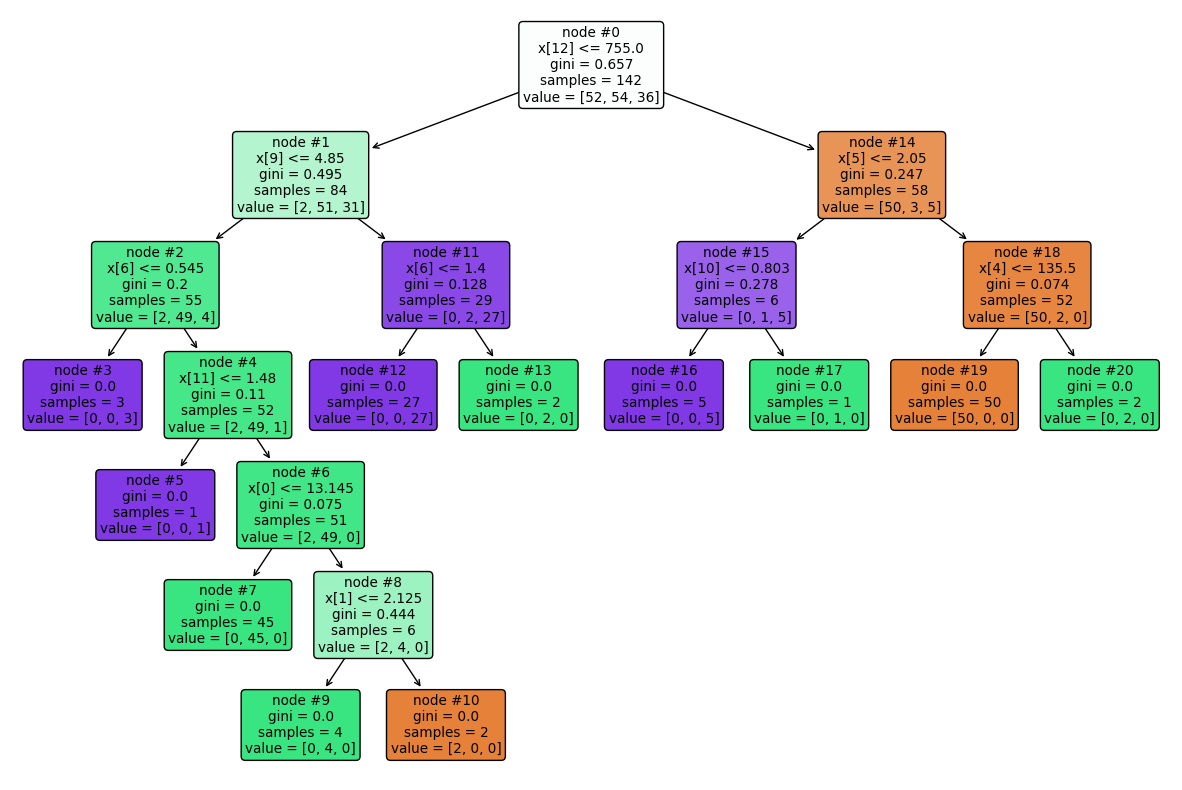

In [3]:
fig = plt.figure(figsize=(15,10))
_ = tree.plot_tree(cls_dt, filled=True, rounded=True, node_ids=True)

In [4]:
# Build the extended tree object
xdt = ext_dt(cls_dt)
# Get the APD of the whole tree
cls_APD = xdt.get_APD()
print(F"This decision tree has an APD of: {cls_APD}")

This decision tree has an APD of: 3.767605633802817


Moreover, absolute and relative APD of each node (its related branch) can be accessed via methods: 
- `get_branchSamples(n)`: sample in the branch of node `n`, this is the absolute APD
- `get_branchAPD(n)`: sample in the branch of node `n`

These are methods of the extended decision tree class.

you can try them using the cell below:

In [5]:
target_node = 6
abs_APD_node = xdt.get_branchSamples(target_node)
APD_node = xdt.get_branchAPD(target_node)

print(F"The node ID {target_node} has APD values as:\n\t-Absolute: {abs_APD_node}\n\t-Relative: {APD_node}")

The node ID 6 has APD values as:
	-Absolute: 57
	-Relative: 1.1176470588235294


Play with the node ID (can be seen in the figure above) and check the values for yourself.

<a name="2.2"></a>
## 2.2 - Benefit of using APD

While traditional tree pruning methods use number of nodes or leaves as a cost factor, here you can see the benefit of using APD to capture the probabilistic effect of samples distribution in the tree.
In the below figures both network have similar number of nodes and leaves. Values written in the nodes show the number of samples in them.

<div> <img src="Figures/Topology1.png" alt="A DT" style="width: 200px;"/></div> 
<div> <img src="Figures/Topology2.png" alt="A DT" style="width: 200px;"/></div>

Although both trees have 5 nodes and 6 leaves, their APD is different. First tree has a 2.7 APD, and the second one has an APD of 2.8.

<a name="3"></a>
## 3 - ORAP algorithm

As learned for CCP, it calculates a cost-complexity factor for all available nodes (and their related branch) and ranked them according to the value. For each alpha value, a node with the minimum factor (called the weakest link) is selected for the removal. This process is continued iteratively till only the root node remains. This procedure has two main issues:
1. Combination of more than one node is not considered for a pruning step
2. After pruning a node it cannot reappear for any further step, although it may help to produce a better combination later on
Therefore, such iterative methods cannot guarantee a global optimum for each desired value.

In this part we introduce ORAP which iteratively checks all possible combinations of pruning branches by use of dynamic programming to assure a global optimum for any desired limit $f^*$.

In a very simplified way, any binary decision tree can be abstracted as the below figure:
<div> <img src="Figures/simplifiedDT.png" alt="A simplified DT" style="width: 200px;"/></div> 
where each child can be either a branch or a leaf for itself. 
For simplicity lets consider each branch is a single node with two leaf children as:
<div> <img src="Figures/simplifiedDepth2.png" alt="A simplified DT" style="width: 200px;"/></div> 

From this form all possible pruning combinations are pruning:

- $B_l$
- $B_r$
- $B_l$ and $B_r$
- $n$

Which are shown graphically as:
<div> <img src="Figures/allPrunings.png" alt="A simplified DT" style="width: 750px;"/></div> 

It is possible to calculate the *cost* (drop in the accuracy or increase in the impurity) and *benefit* (reduction in the required resource which is APD here) for each of these case.
Among these options we filter those which fulfill the requirement of $\mathcal{F} \leq f^*$ and put them into a set. To be noted that it is possible to have an empty set, or there is no pruning which fulfils the requirement.
From this set we pick that one with the highest accuracy. In this way selection of the best performing pruning for this simplified case is assured.

In the next step consider that for each of the children branches has a deeper branch in it. We repeat this process till reaching this simplified case (base form) and calculate the optimum solution for it.
Then, when checking its upper case we use this optimal case for building the above mentioned pruning cases.
In this sense we check all possible combinations with a reduced computational need, and can guarantee to keep the best solution for each node.
Continuing this procedure till highest level of the tree provides the optimum solution at the root node.

The overall algorithm can be abstracted as:
1. Train a fully-grown tree
2. Categorize each node according to its depth
3. start form deepest nodes' level (leaves cannot be pruned) depth = $d$
4. select a node $n$ in the current depth (which is not checked yet)
5. calculate benefit and cost for each of 4 pruning cases
6. select cases which fulfil the APD criteria
7. among cases from step 6 pick the case with the minimum cost (lowest drop in the accuracy)
8. store specifications of the optimum case for the node $n$
9. if there is a nodes in the current depth not checked -> go to 4
10. if root is not reached -> reduce the depth $d$ and go to 4
11. if root is reached -> return root optimum specification as the result


<a name="3.1"></a>
## 3.1 - ORAP implementation

Up to here the overall concept of optimal pruning for a single APD value was shown. However, it is common for a model designer to modify this limit and require a new pruning. To avoid repeating the optimization procedure, implemented ORAP method here will go through a tree and builds a sequence of pruning with best performing accuracy at each possible APD value in the tree. To be noted that changes in APD is not a continuous value and has specific steps according to the distribution of samples in the tree.

In case of interest to understand the implementation review the source code available in the repo. A scientific paper with detail explanation is in preparation.

You can get the pruning sequence found by implementation of the ORAP using `get_ORAP_sequence(dt_base)`, with `dt_base` as your initial tree (preferably a fully-grown tree). There is an optional argument as `use_parallel` which lets the program to use multiple processor cores. This is useful for very deep trees, though its overhead handling makes it not efficient for shallow trees. Therefore, do not use it except necessary!

This function gives you a sequence of pruning with a list of nodes to be pruned for each step. Accordingly, it gives you the change in absolute APD of the pruned tree on the training data and change in the misclassification.

In [6]:
ORAP_sequence = get_ORAP_sequence(cls_dt)

[10 (d:6)] | Opting ===>
[10] ===> Ready |
[9 (d:6)] | Opting ===>
[9] ===> Ready |
[8 (d:5)] | Opting ===>
[8] ===> Ready |
[7 (d:5)] | Opting ===>
[7] ===> Ready |
[6 (d:4)] | Opting ===>
[6] ===> Ready |
[5 (d:4)] | Opting ===>
[5] ===> Ready |
[20 (d:3)] | Opting ===>
[20] ===> Ready |
[19 (d:3)] | Opting ===>
[19] ===> Ready |
[17 (d:3)] | Opting ===>
[17] ===> Ready |
[16 (d:3)] | Opting ===>
[16] ===> Ready |
[13 (d:3)] | Opting ===>
[13] ===> Ready |
[12 (d:3)] | Opting ===>
[12] ===> Ready |
[4 (d:3)] | Opting ===>
[4] ===> Ready |
[3 (d:3)] | Opting ===>
[3] ===> Ready |
[18 (d:2)] | Opting ===>
[18] ===> Ready |
[15 (d:2)] | Opting ===>
[15] ===> Ready |
[11 (d:2)] | Opting ===>
[11] ===> Ready |
[2 (d:2)] | Opting ===>
[2] ===> Ready |
[14 (d:1)] | Opting ===>
[14] ===> Ready |
[1 (d:1)] | Opting ===>
[1] ===> Ready |
[0 (d:0)] | Opting ===>
[0] ===> Ready |


Output of this function is the pruning sequence which can be seen using `ShowSequence` method.

In [7]:
ORAP_sequence.ShowSequence()

--------------------
D(APD):	[0, 6, 57, 109, 115, 161, 167, 190, 216, 222, 245, 251, 254, 280, 309, 329, 335, 393, 535]
Miss.:	[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 16, 35, 36, 41, 88]
Rmvd.:	[[], [15], [6], [4], [4, 15], [4, 18], [4, 15, 18], [4, 11, 18], [2, 18], [2, 15, 18], [2, 11, 18], [2, 11, 15, 18], [4, 11, 14], [2, 14], [2, 11, 14], [1, 18], [1, 15, 18], [1, 14], [0]]
--------------------


This output has different elements with specifications of each single step in the pruning of the tree. Key factors of this class can be accessed using these elements:
- Changes in the absolute APD shown above with *D(APD)*: `cost`
- Changes in the miss-classification shown above with *Miss.*: `miss`
- Removed node in each step shown above with *Rmvd.*: `removed`

In the above sequence, first prune element is the initial tree without any branch removal. This does change neither APD, nor the miss-classification.
Next step is pruning is removal of the branch with the root node 15. This will reduce absolute APD by 6 samples and causes 1 sample to be classified wrong. Check this in the figure of the tree.

One key aspect to be noted here is that each step in the pruning is made of an absolute list of elements and in contrast to the CCP, it is not iterative.
Therefore, in the third element of pruning we remove only node 6 from the **initial tree**.

To check this, we can build trees and visualize them graphically.
For this purpose there is the function `series_prune(base_dt, node_series)` which removes a series of nodes (`node_series`) from an initial tree (`base_dt`).

Pruned nodes: [1, 15, 18]


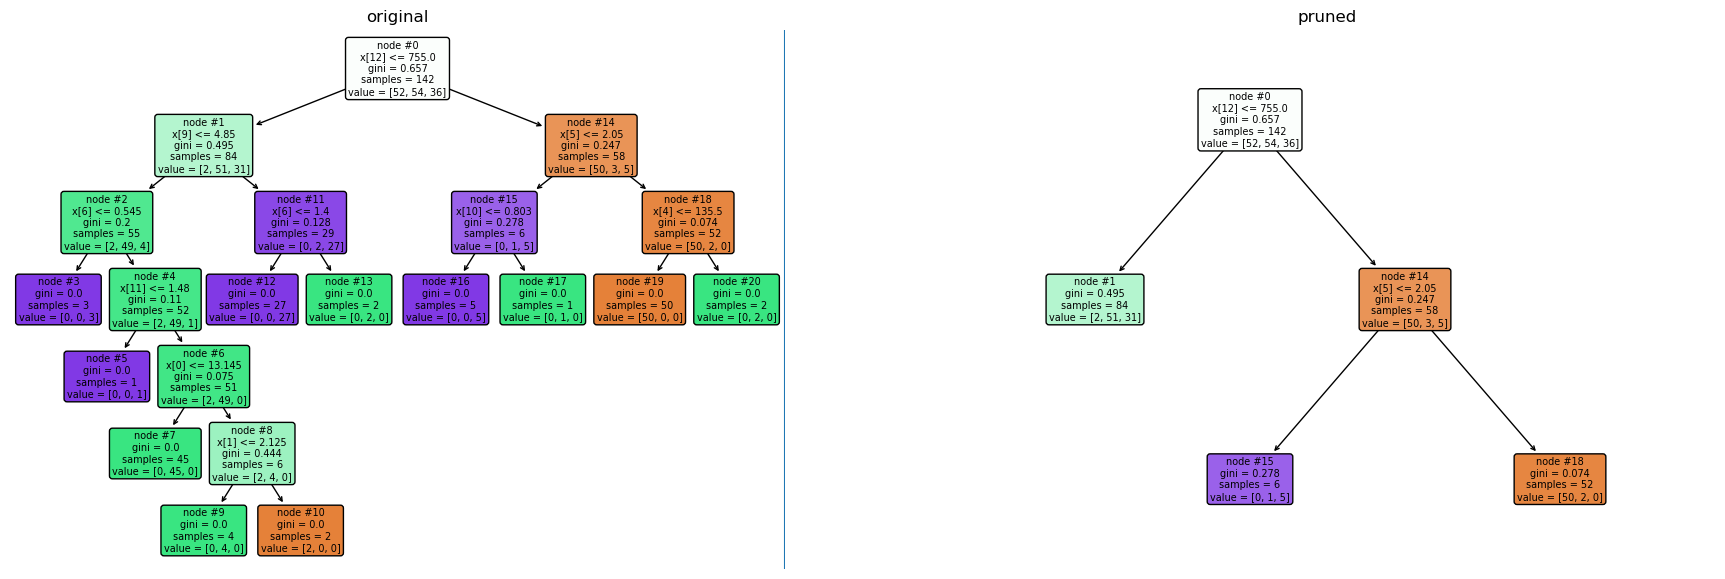

In [8]:
# Get the list of lists for the pruning sequence
remove_sequence = ORAP_sequence.removed
# Select a pruning step
prune_step = -3
# Extract its list
node_series = remove_sequence[prune_step]
# Prune the tree
print(F"Pruned nodes: {node_series}")
pruned_dt = series_prune(cls_dt, node_series)
# Visualize the original tree
ft_size = 7
fig, axs = plt.subplots(1, 2,figsize=(22,7))
plt.subplot(1, 2, 1)
tree.plot_tree(cls_dt, filled=True, rounded=True, node_ids=True, fontsize=ft_size)
axs[0].set_title("original")
axs[0].axvline(x=1)
plt.subplot(1, 2, 2)
tree.plot_tree(pruned_dt, filled=True, rounded=True, node_ids=True, fontsize=ft_size)
_=axs[1].set_title("pruned")

<a name="4"></a>
## 4 - ORAP performance

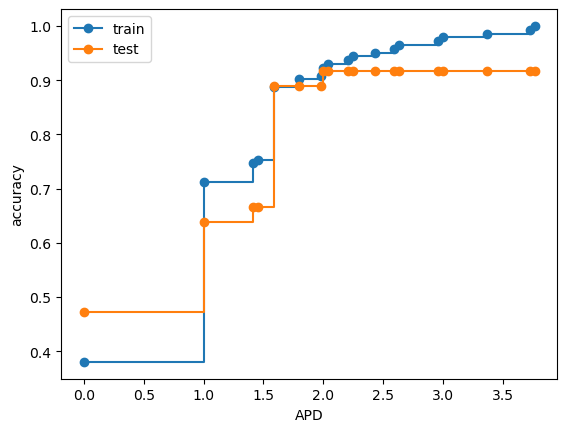

In [9]:
clfs = []
for prune_list in remove_sequence:
    clf = series_prune(cls_dt, prune_list)
    clfs.append(clf)
all_APD = [ext_dt(clf).get_APD() for clf in clfs]
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("APD")
ax.set_ylabel("accuracy")
ax.plot(all_APD, train_scores, marker="o", label="train", drawstyle="steps-pre")
ax.plot(all_APD, test_scores, marker="o", label="test", drawstyle="steps-pre")
_=ax.legend()

In [10]:
print(cls_dt.score(X_test, y_test))
print(pruned_dt.score(X_test, y_test))


0.9166666666666666
0.6666666666666666


<a name="5"></a>
## 5 - Deeper understanding of APD's probabilistic nature 

Comparison of ORAP and CCP according to the APD and number of nodes.

<a name="6"></a>
## 6 - ORAP to avoid over-fitting

Similar to CCP, it is possible to use ORAP for check and avoiding the over-fitting.
In a similar manner, we build all trees in the pruning sequence, and check the accuracy of them all on the train and test data.

In [11]:
from sklearn.datasets import load_breast_cancer 
X_ovf, y_ovf = load_breast_cancer(return_X_y=True)
X_train_ovf, X_test_ovf, y_train_ovf, y_test_ovf = train_test_split(X_ovf, y_ovf, test_size = 0.1, random_state=7)
BC_dt = DecisionTreeClassifier(random_state=0)
_ = BC_dt.fit(X_train_ovf, y_train_ovf)
BC_ORAP_sequence = get_ORAP_sequence(BC_dt)
BC_remove_sequence = BC_ORAP_sequence.removed

BC_clfs = []
for prune_list in BC_remove_sequence:
    BC_clf = series_prune(BC_dt, prune_list)
    BC_clfs.append(BC_clf)
BC_APD = [ext_dt(clf).get_APD() for clf in BC_clfs]
BC_train_scores = [clf.score(X_train_ovf, y_train_ovf) for clf in BC_clfs]
BC_test_scores = [clf.score(X_test_ovf, y_test_ovf) for clf in BC_clfs]

[14 (d:8)] | Opting ===>
[14] ===> Ready |
[13 (d:8)] | Opting ===>
[13] ===> Ready |
[19 (d:7)] | Opting ===>
[19] ===> Ready |
[18 (d:7)] | Opting ===>
[18] ===> Ready |
[12 (d:7)] | Opting ===>
[12] ===> Ready |
[11 (d:7)] | Opting ===>
[11] ===> Ready |
[9 (d:7)] | Opting ===>
[9] ===> Ready |
[8 (d:7)] | Opting ===>
[8] ===> Ready |
[25 (d:6)] | Opting ===>
[25] ===> Ready |
[24 (d:6)] | Opting ===>
[24] ===> Ready |
[17 (d:6)] | Opting ===>
[17] ===> Ready |
[16 (d:6)] | Opting ===>
[16] ===> Ready |
[10 (d:6)] | Opting ===>
[10] ===> Ready |
[7 (d:6)] | Opting ===>
[7] ===> Ready |
[41 (d:5)] | Opting ===>
[41] ===> Ready |
[40 (d:5)] | Opting ===>
[40] ===> Ready |
[23 (d:5)] | Opting ===>
[23] ===> Ready |
[22 (d:5)] | Opting ===>
[22] ===> Ready |
[15 (d:5)] | Opting ===>
[15] ===> Ready |
[6 (d:5)] | Opting ===>
[6] ===> Ready |
[42 (d:4)] | Opting ===>
[42] ===> Ready |
[39 (d:4)] | Opting ===>
[39] ===> Ready |
[30 (d:4)] | Opting ===>
[30] ===> Ready |
[29 (d:4)] | Opting

And then we plot the performance according to the APD to see the accuracy behavior.

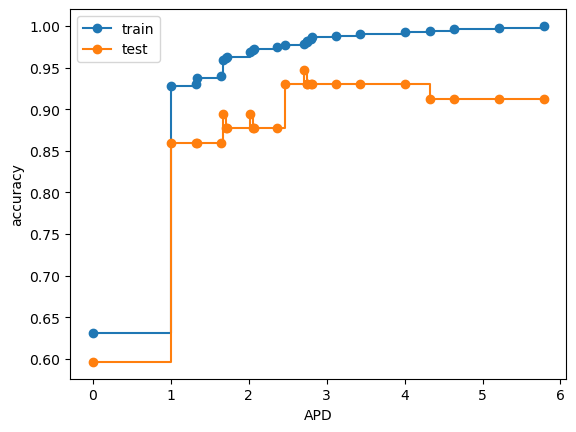

In [12]:
fig, ax = plt.subplots()
ax.set_xlabel("APD")
ax.set_ylabel("accuracy")
ax.plot(BC_APD, BC_train_scores, marker="o", label="train", drawstyle="steps-pre")
ax.plot(BC_APD, BC_test_scores, marker="o", label="test", drawstyle="steps-pre")
_=ax.legend()

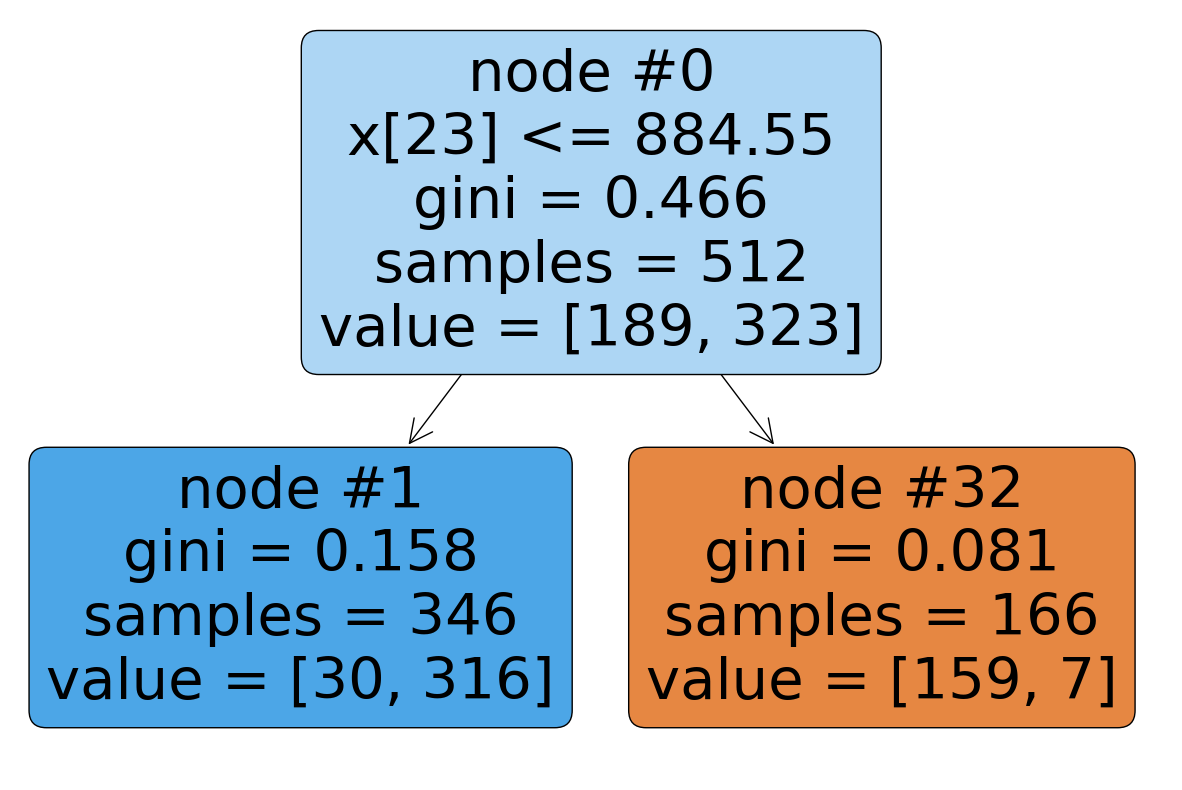

In [13]:
fig = plt.figure(figsize=(15,10))
_ = tree.plot_tree(BC_clfs[-2], filled=True, rounded=True, node_ids=True)

As discussed before, accuracy of the test data may have small jitters when the distribution of the test data is no representative. Therefore, we have to focus on the larger trends in the test data behavior. For instance in the above figure, jitters around APD of 2 and 2.7 are most probably due to the nature of the data and it is better to focus on the general trend when the accuracy is dropped (around 2.5).